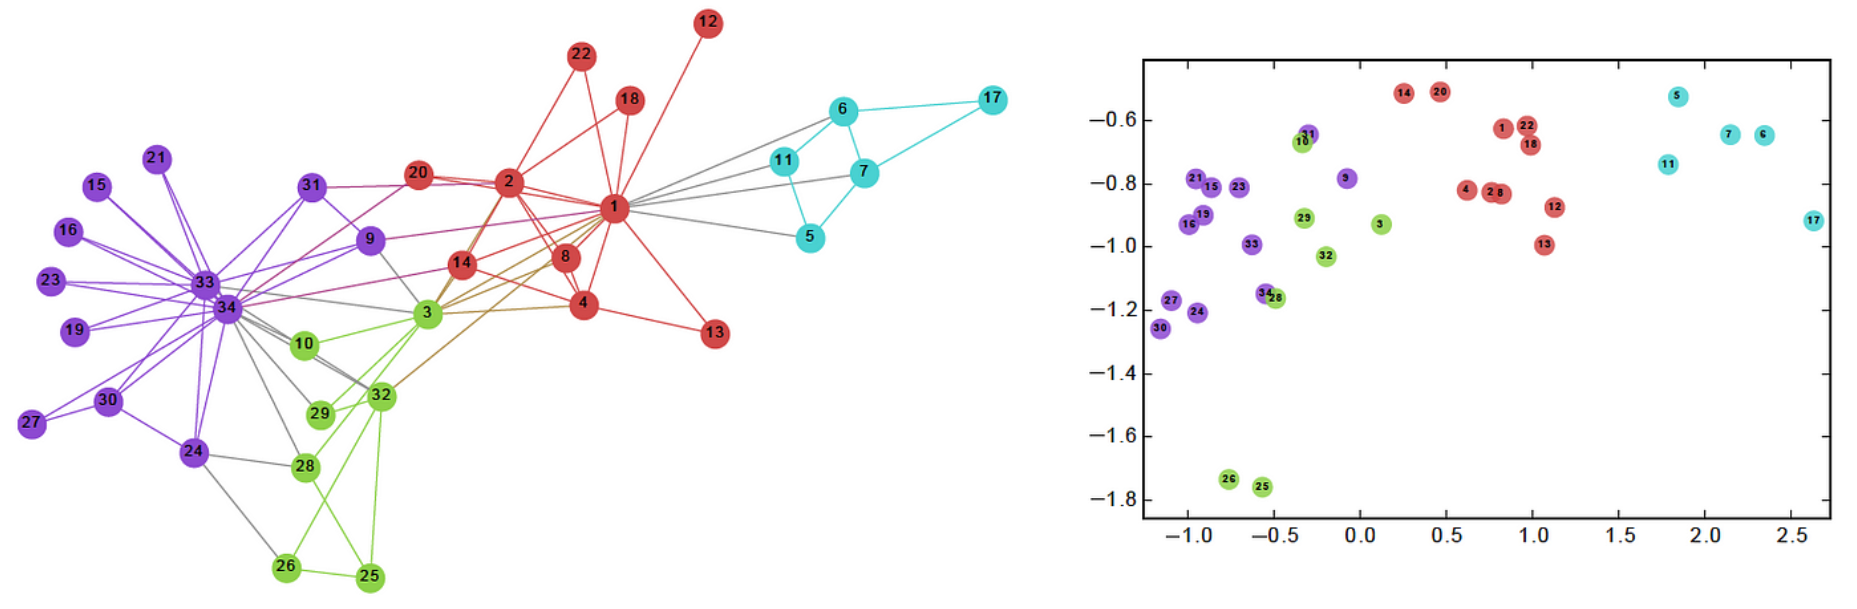



# Conceptualizing the Graph Embeddings

1. **DeepWalk Algorithm**:
   - DeepWalk is an unsupervised graph embedding algorithm that learns representations of nodes in a graph by leveraging the concept of random walks.
   - It aims to capture structural information of the graph by generating random walks and treating them as sentences in a corpus.
   - Each node in the graph is considered as a starting point, and multiple random walks are generated from each node.
   - The random walks are used to capture the local neighborhood information of nodes.

2. **Word2Vec Model**:
   - Word2Vec is a popular algorithm for learning word embeddings from large textual datasets.
   - In this context, the Word2Vec model is utilized to learn embeddings for nodes (books) based on the generated random walks.
   - The Word2Vec model represents each node as a vector of fixed dimensions (embedding dimension).
   - It considers the context of each node by using a sliding window over the random walks.
   - The model learns to predict the probability of neighboring nodes given the current node (Skip-gram or Continuous Bag-of-Words).

3. **Code Explanation**:
   - The code first constructs a bipartite graph using the provided dataset, where nodes represent books and users, and edges represent ratings.
   - The DeepWalk class is then instantiated with the graph and various parameters.
   - The class determines the best neighbors for each node based on edge weights and selection criteria.
   - Random walks are generated from each node, excluding user nodes.
   - The walks are passed to the Word2Vec model for training.
   - The model is built and trained using the walks, updating the embeddings based on the provided context window.
   - Finally, the trained model is used to evaluate similarities between book titles.

By combining DeepWalk and Word2Vec, the code aims to learn meaningful and semantically rich embeddings for the books in the graph. These embeddings can capture the structural relationships and similarities between books, which can be useful for various downstream tasks such as recommendation systems, community detection, or clustering based on book similarities.

# Starting with the code

In [52]:
import numpy as np
from tqdm import tqdm
import random, math

import warnings
warnings.filterwarnings("ignore")

# Loading The Dataset

In [34]:
import pandas as pd

books = pd.read_csv("/kaggle/input/book-recommendation-dataset/Books.csv")
users = pd.read_csv("/kaggle/input/book-recommendation-dataset/Users.csv")
ratings = pd.read_csv("/kaggle/input/book-recommendation-dataset/Ratings.csv")

print("Books Shape:", books.shape)
print("Users Shape:", users.shape)
print("Ratings Shape:", ratings.shape)

Books Shape: (271360, 8)
Users Shape: (278858, 3)
Ratings Shape: (1149780, 3)


In [35]:
books.head(3)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...


In [36]:
users.head(3)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN


In [37]:
ratings.head(3)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0


### Merging and Filtering

In [38]:
# Merging Books and Ratings
df = ratings.merge(books, on="ISBN")

# Removing Duplicates
df = df[~ df.duplicated(subset=["User-ID", "Book-Title"], keep='first')]

# printing shape of merged dataframe
print("Shape:", df.shape)

# Showing 3 random samples
df.sample(3)

Shape: (1026358, 10)


,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
335987,167478,0061031127,6,The Bronze Horseman,Paullina Simons,2002,HarperTorch,http://images.amazon.com/images/P/0061031127.0...,http://images.amazon.com/images/P/0061031127.0...,http://images.amazon.com/images/P/0061031127.0...
463524,104209,0385503954,0,Atonement: A Novel,Ian McEwan,2002,Nan A. Talese,http://images.amazon.com/images/P/0385503954.0...,http://images.amazon.com/images/P/0385503954.0...,http://images.amazon.com/images/P/0385503954.0...
710390,70772,0425093476,5,Clive Barker's Books of Blood (Clive Barker's ...,Clive Barker,1992,Berkley Publishing Group,http://images.amazon.com/images/P/0425093476.0...,http://images.amazon.com/images/P/0425093476.0...,http://images.amazon.com/images/P/0425093476.0...


### Filtering Important Users and Books

In [39]:
n_ratings_for_user_selection = 200
n_ratings_for_book_selection = 50

print(f"selecting only the users that have rated more than {n_ratings_for_user_selection} books")
print(f"selecting only the books that have been rated more than {n_ratings_for_book_selection} times")

selecting only the users that have rated more than 200 books
selecting only the books that have been rated more than 50 times


In [40]:
print(
	len(df['User-ID'].unique()),
	len(df['Book-Title'].unique())
)

92106 241071


In [41]:
# Filtering Users
filtered_users = df.groupby("User-ID").count()['Book-Rating'] > n_ratings_for_user_selection
filtered_users = filtered_users[filtered_users].index

df = df[df['User-ID'].isin(filtered_users)]

In [42]:
# Filtering Books
filtered_books = df.groupby("Book-Title").count()['Book-Rating'] > n_ratings_for_book_selection
filtered_books = filtered_books[filtered_books].index

df = df[df['Book-Title'].isin(filtered_books)]

In [43]:
print(
	len(df['User-ID'].unique()),
	len(df['Book-Title'].unique())
)

807 640


### Seperating Agents

- The code separates the agents (books and users) from the filtered DataFrame 'df' and creates three variables: 'BOOKS', 'USERS', and 'EDGES'.
- **BOOKS** is a sorted list of unique book titles from the 'Book-Title' column of the DataFrame.
- **USERS** is a sorted list of unique user IDs from the 'User-ID' column of the DataFrame.
- **EDGES** is a list of lists, where each inner list represents an edge between a book and a user. Each inner list contains three items: the book title, the user ID, and the book rating.


In [47]:
BOOKS = sorted(df['Book-Title'].unique().tolist())
USERS = sorted(df['User-ID'].unique().tolist())
EDGES = df[[
    'Book-Title',
    'User-ID',
    'Book-Rating'
]].values.tolist()

len(USERS), len(BOOKS), len(EDGES)

(807, 640, 53265)

In [48]:
print("BOOKS", random.choices(BOOKS, k=3))
print("USERS", random.choices(USERS, k=3))
print("EDGES", random.choices(EDGES, k=3))

BOOKS ['Cold Mountain : A Novel', 'The Reader', 'Roses Are Red (Alex Cross Novels)']
USERS [23288, 143415, 155219]
EDGES [['Mystic River', 78973, 0], ['Little Altars Everywhere: A Novel', 3363, 0], ['The Bridges of Madison County', 228998, 0]]


# Constructing Graph

In [49]:
import networkx as nx

G = nx.Graph()

# Add nodes
G.add_nodes_from(BOOKS, bipartite=0)
G.add_nodes_from(USERS, bipartite=1)

# Add edges
G.add_weighted_edges_from(EDGES)

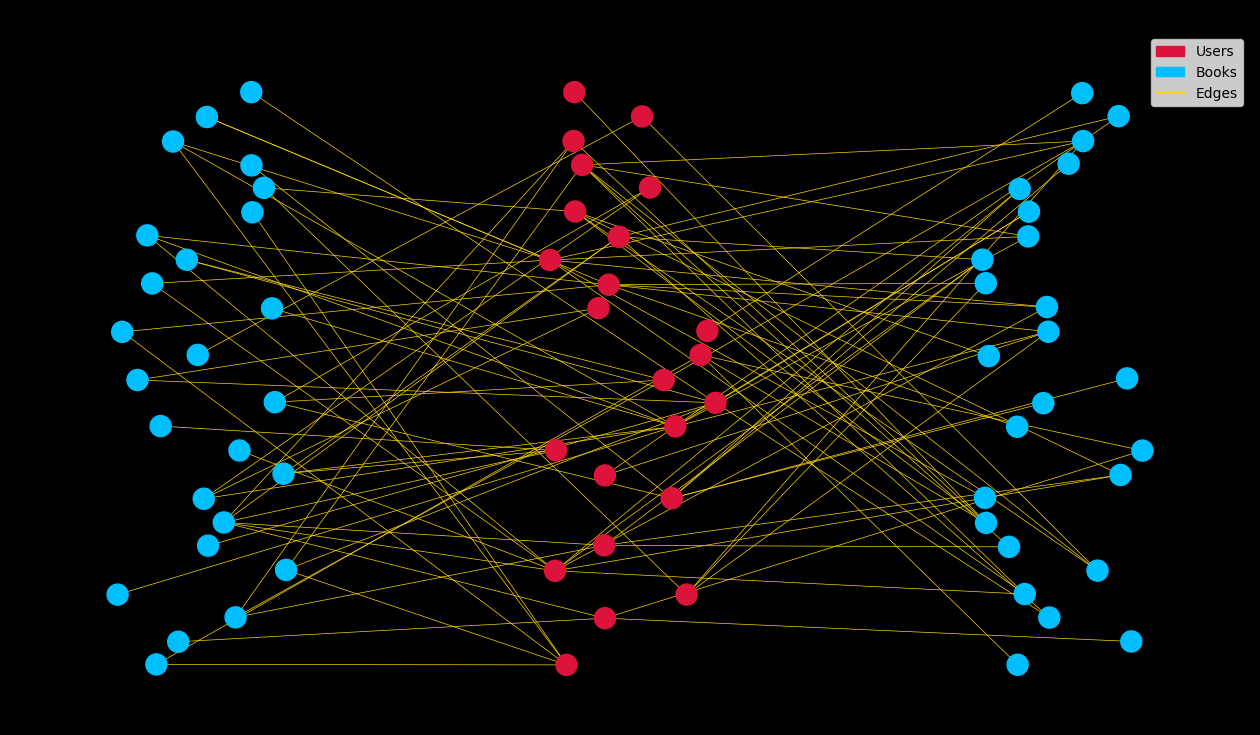

In [51]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# PLOTTING THE GRAPH

k = 25     # No of books to display in the graph
c = [
    "crimson",
    "deepskyblue",
]
edge_color='gold'
figsize = (16, 9)

# SELECTING RANDOM NODES
book_nodes = random.choices(BOOKS, k=k)
user_nodes = []
for node in book_nodes:
    user_nodes.extend(G.neighbors(node))
user_nodes = random.choices(list(set(user_nodes)), k=k*2)
subgraph = G.subgraph(user_nodes + book_nodes)

# GIVING POSITION
diff = 0.04
get_rand = lambda : np.random.uniform(-diff, diff)
pos_c = [( node, [ 0 + get_rand(), i + get_rand()] ) for i, node in enumerate(book_nodes)]
pos_l = [( node, [ 0.2 + get_rand(), i + get_rand()] ) for i, node in enumerate(user_nodes[:k])]
pos_r = [( node, [-0.2 + get_rand(), i + get_rand()] ) for i, node in enumerate(user_nodes[k:])]
pos = pos_c + pos_l + pos_r
pos = {k: v for k, v in pos}

# GIVING COLORS
colors = []
for node in subgraph.nodes():
    if node in book_nodes:
        colors.append(c[0])
    else:
        colors.append(c[1])

# ADDING LEGEND
edge_line = mlines.Line2D([], [], color=edge_color, label='Edges')
node_1_path = mpatches.Patch(color=c[0], label='Users')
node_2_path = mpatches.Patch(color=c[1], label='Books')

# PLOTTING
fig, ax = plt.subplots(figsize=figsize)
nx.draw_networkx(subgraph, pos, with_labels=False, node_size=230, edge_color=edge_color, width=0.5, node_color=colors)
ax.set_facecolor('black')
ax.axis('off')
fig.set_facecolor('black')
plt.legend(handles=[node_1_path, node_2_path, edge_line])
plt.show()

# Generating Corpus From Graph

In [54]:
# DEEPWALK PARAMETERS
MAX_WALK_LEN = 40       # maximum length a sentence can have in corpus
N_WALKS_PER_NODE = 50   # these many sentences will be generated by taking one node as start

In [56]:
class DeepWalk():
    def __init__(self, graph):
        self.G = graph
        self.nodes = {n for n, d in self.G.nodes(data=True) if d['bipartite'] == 0}
        
        self.min_weight = 3   # include edges only that have this minimum weight
        self.k = 50     # percentage of nodes to select

        # FINDING BEST NEIGHBORS FOR EACH NODE
        self.sorted_selected_neighbors = {}
        for node in self.G.nodes:
            # extracting all the neigbors of this node
            selected = self.G[node].items()
            # sorting all neighbor nodes based on weight
            selected = sorted(selected, key=lambda x: x[1]['weight'], reverse=True)
            # extracting the nodes name with given weight
            selected = [i[0] for i in selected if i[1]['weight'] >= self.min_weight]
            # finding the number of nodes to be selected at last
            till = math.ceil(len(selected) * self.k/100)
            # selecting the calculated number of nodes
            self.sorted_selected_neighbors[node] = selected[:till]

    def select_neighbor(self, walk):
        node = walk[-1]
        criteria = self.sorted_selected_neighbors[node]
        try: return random.choice(criteria)
        except: pass

    def random_walk(self, start_node, max_walk_length):
        walk = [start_node]
        for _ in range(max_walk_length - 1):
            node = self.select_neighbor(walk)
            if node == None: break
            walk.append(node)
            
        # removing user nodes from the graph
        walk = [node for i, node in enumerate(walk) if i%2 == 0]
        
        return walk

    def get_walks(self, max_walk_length, num_walks_per_node):
        
        max_walk_length = max_walk_length * 2    # as there are users also included in the walk

        walks = []
        with tqdm(total=num_walks_per_node * len(self.nodes)) as pbar:  # using tqdm to measure progress
            for node in self.nodes:
                for _ in range(num_walks_per_node):
                    walk = self.random_walk(node, max_walk_length)
                    walks.append(walk)
                    pbar.update(1)

        return walks

In [57]:
deepwalk = DeepWalk(G)

walks = deepwalk.get_walks(MAX_WALK_LEN, N_WALKS_PER_NODE)

100%|██████████| 32000/32000 [00:03<00:00, 10077.89it/s]


In [59]:
print("Total Number of Walks:", len(walks))
print("First Walk:", walks[0])

Total Number of Walks: 32000
First Walk: ['Jack &amp; Jill (Alex Cross Novels)', 'A Heartbreaking Work of Staggering Genius', 'K Is for Killer (Kinsey Millhone Mysteries (Paperback))', 'I Is for Innocent', 'Harry Potter and the Order of the Phoenix (Book 5)', 'The Client', 'A Painted House', 'Good in Bed', 'Key of Valor (Roberts, Nora. Key Trilogy, 3.)', 'Carolina Moon', 'Harry Potter and the Prisoner of Azkaban (Book 3)', 'Anne Frank: The Diary of a Young Girl', 'Harry Potter and the Prisoner of Azkaban (Book 3)', 'Misery', 'Zoya', 'Misery', 'Master of the Game', 'The Secret Life of Bees', 'To Kill a Mockingbird', 'Intensity', 'Winter Moon', 'Icebound', 'On the Street Where You Live', 'M Is for Malice', "Charlotte's Web (Trophy Newbery)", 'Harry Potter and the Prisoner of Azkaban (Book 3)', 'Harry Potter and the Order of the Phoenix (Book 5)', "Tuesdays with Morrie: An Old Man, a Young Man, and Life's Greatest Lesson", 'A Time to Kill', 'Good Omens', 'Like Water for Chocolate : A Nove

# Generating Graph Embeddings

The provided code demonstrates the usage of the `Word2Vec` model from the `gensim` library. Here's a brief explanation of the theory behind the code:

1. Importing the Required Libraries:
   - The code imports the `Word2Vec` model from the `gensim.models` module.

2. Initializing the Model:
   - The `Word2Vec` model is initialized with various parameters:
     - `vector_size`: The dimensionality of the word embeddings (EMB_DIM).
     - `window`: The maximum distance between the target word and its neighboring words within a sentence (WINDOW_SIZE).
     - `min_count`: The minimum count of words to consider when building the vocabulary (0 means all words are considered).
     - `sg`: The training algorithm to use. If USE_SKIPGRAPM is False, the Continuous Bag of Words (CBOW) algorithm is used; otherwise, Skip-gram is used.
     - `epochs`: The number of iterations (epochs) over the corpus during training (EPOCHS).

3. Building Vocabulary:
   - The model's vocabulary is built based on the provided walks (sequences of nodes obtained from graph walks).

4. Training the Model:
   - The model is trained on the provided walks.
   - The `train` method is called with the walks, the total number of examples (length of walks), and the number of epochs from the model.

5. Getting Embeddings for the Books:
   - The trained model is used to obtain embeddings for the books in the `BOOKS` list.
   - The `wv` property of the model provides access to the word vectors, and `model.wv[BOOKS]` retrieves the embeddings for the books.
   - The resulting embeddings are stored in the `EMBEDDINGS` variable.

6. Checking the Shape of Embeddings:
   - The code prints the shape of the obtained embeddings (`EMBEDDINGS.shape`), which represents the number of books and the dimensionality of the embeddings.

7. Finding Most Similar Books:
   - The `most_similar` method of the model's `wv` property is used to find the most similar books to a given book.
   - The code calls `model.wv.most_similar("Animal Farm")` to find the most similar books to "Animal Farm" based on their embeddings.

The `Word2Vec` model is trained to learn word (or node) embeddings based on the given walks, which can later be used for various natural language processing or graph-related tasks such as similarity calculations, clustering, or classification.

In [60]:
# EMBEDDING PARAMETERS
EMB_DIM = 128
WINDOW_SIZE = 2
USE_SKIPGRAPM = False
EPOCHS = 10

In [61]:
from gensim.models import Word2Vec

# Initializing the Model
model = Word2Vec(
    vector_size = EMB_DIM,
    window = WINDOW_SIZE,
    min_count = 0,
    sg = USE_SKIPGRAPM,
    epochs = EPOCHS
)

# Building Vocabulary
model.build_vocab(walks)

# Trainig the Model
model.train(
    walks,
    total_examples = len(walks),
    epochs = model.epochs
)

(11396539, 12800000)

In [62]:
model.wv.most_similar("Animal Farm")

[('Midnight', 0.4730284512042999),
 ('Violin', 0.3967288136482239),
 ('The Catcher in the Rye', 0.3922467529773712),
 ('Angus, Thongs and Full-Frontal Snogging: Confessions of Georgia Nicolson',
  0.3877190947532654),
 ('American Gods', 0.3573043644428253),
 ('Like Water for Chocolate : A Novel in Monthly Installments with Recipes, Romances, and Home Remedies',
  0.3518407940864563),
 ('Watership Down', 0.35129910707473755),
 ('Beloved (Plume Contemporary Fiction)', 0.3367733359336853),
 ('About a Boy', 0.3353714942932129),
 ('1984', 0.3294317424297333)]

In [63]:
model.wv.most_similar("To Kill a Mockingbird")

[("The Color of Water: A Black Man's Tribute to His White Mother",
  0.3794633746147156),
 ('Snow Falling on Cedars', 0.3384957015514374),
 ('Five Quarters of the Orange', 0.3199497163295746),
 ('How Stella Got Her Groove Back', 0.3197801411151886),
 ("Song of Solomon (Oprah's Book Club (Paperback))", 0.3150259256362915),
 ("Sophie's World: A Novel About the History of Philosophy",
  0.30403029918670654),
 ("Songs in Ordinary Time (Oprah's Book Club (Paperback))",
  0.3018641471862793),
 ('The Secret Life of Bees', 0.29427728056907654),
 ('One True Thing', 0.2831243574619293),
 ('The Tao of Pooh', 0.2827152907848358)]

In [64]:
model.wv.most_similar('Harry Potter and the Prisoner of Azkaban (Book 3)')

[('Harry Potter and the Chamber of Secrets (Book 2)', 0.7952761054039001),
 ('Harry Potter and the Goblet of Fire (Book 4)', 0.7670604586601257),
 ('Harry Potter and the Order of the Phoenix (Book 5)', 0.6664018630981445),
 ("Harry Potter and the Sorcerer's Stone (Book 1)", 0.6142432689666748),
 ("Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))",
  0.5775092840194702),
 ('The Tao of Pooh', 0.5174782276153564),
 ('The Two Towers (The Lord of the Rings, Part 2)', 0.4320714473724365),
 ('The Fellowship of the Ring (The Lord of the Rings, Part 1)',
  0.4218562841415405),
 ('Interview with the Vampire', 0.41376954317092896),
 ("Foucault's Pendulum", 0.40924638509750366)]

In [67]:
model.wv.similarity("Animal Farm", "Harry Potter and the Prisoner of Azkaban (Book 3)")

0.13800776